In [1]:
! pip install geemap

In [1]:
import geemap

In [2]:
map = geemap.Map(center=(26.293805525369162, 77.54585509702882), zoom=5)
map


Successfully saved authorization token.


Map(center=[26.293805525369162, 77.54585509702882], controls=(WidgetControl(options=['position', 'transparent_…

In [3]:
map.add_basemap('SATELLITE')

#map.set_center(30.6302, 76.7248)
#map.set_center(30.631446509381377, 76.72447156832993)


In [5]:

# Go to Plaksha
map.set_center(76.72447156832993, 30.631446509381377 , zoom=16)
#map.set_center(76.7248, 30.6302)
#map.set_zoom(8)

In [4]:
basemaps = geemap.basemaps

for basemap in basemaps:
    print(basemap)

OpenStreetMap
Esri.WorldStreetMap
Esri.WorldImagery
Esri.WorldTopoMap
FWS NWI Wetlands
FWS NWI Wetlands Raster
NLCD 2021 CONUS Land Cover
NLCD 2019 CONUS Land Cover
NLCD 2016 CONUS Land Cover
NLCD 2013 CONUS Land Cover
NLCD 2011 CONUS Land Cover
NLCD 2008 CONUS Land Cover
NLCD 2006 CONUS Land Cover
NLCD 2004 CONUS Land Cover
NLCD 2001 CONUS Land Cover
USGS NAIP Imagery
USGS NAIP Imagery False Color
USGS NAIP Imagery NDVI
USGS Hydrography
USGS 3DEP Elevation
ESA Worldcover 2020
ESA Worldcover 2020 S2 FCC
ESA Worldcover 2020 S2 TCC
ESA Worldcover 2021
ESA Worldcover 2021 S2 FCC
ESA Worldcover 2021 S2 TCC
BaseMapDE.Color
BaseMapDE.Grey
BasemapAT.basemap
BasemapAT.grau
BasemapAT.highdpi
BasemapAT.orthofoto
BasemapAT.overlay
BasemapAT.surface
BasemapAT.terrain
CartoDB.DarkMatter
CartoDB.DarkMatterNoLabels
CartoDB.DarkMatterOnlyLabels
CartoDB.Positron
CartoDB.PositronNoLabels
CartoDB.PositronOnlyLabels
CartoDB.Voyager
CartoDB.VoyagerLabelsUnder
CartoDB.VoyagerNoLabels
CartoDB.VoyagerOnlyLabe

In [6]:
# Add the hybrid layer (satellite + labels)
map.add_tile_layer(
    url="http://mt1.google.com/vt/lyrs=s,h&x={x}&y={y}&z={z}",
    name="Google Hybrid",
    attribution="Google"
)


In [7]:
import ee
#import geemap.core as geemap

Let us now try to retreive and visualize the satellite imagery for LandSat around the Plaksha region. Here's the Earth Engine Catalog [link](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=en#colab-python). Notice the cool roof on Infosys building.

In [8]:
dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(
    '2021-05-01', '2021-06-01'
)


# Applies scaling factors.
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )


dataset = dataset.map(apply_scale_factors)

visualization = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0.0,
    'max': 0.3,
}

map.add_layer(dataset, visualization, 'Land Surface Temperature')


This is great but probably a few too many pixels. What's the latest real-time medium resolution image we can get? Sentinel 2. Let's try to retreive this.

In [9]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)


dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate('2025-01-01', '2025-01-30')
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .map(mask_s2_clouds)
)

visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

map.add_layer(dataset.mean(), visualization, 'RGB')

In [10]:
import geopandas as gpd
import geemap
import json

# Load the shapefile
shapefile = 'data/potential-construction.shp'
gdf = gpd.read_file(shapefile)

# Convert the GeoDataFrame to GeoJSON format
geojson = gdf.to_json()

# Parse the GeoJSON string to a dictionary
geojson_dict = json.loads(geojson)

# Convert the GeoJSON to an Earth Engine object
ee_object = geemap.geojson_to_ee(geojson_dict)

# Add the EE object to the map
map.addLayer(ee_object, {}, 'Potential Construction Sites')


In [13]:
dem = ee.Image('USGS/SRTMGL1_003')

vis_params = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
}

map.addLayer(dem, vis_params, 'SRTM DEM', True, 1)


In [14]:
import ee
from datetime import datetime,timedelta

# Convert the shapefile geometry to GeoJSON
aoi_geojson = gdf.geometry.iloc[0].__geo_interface__

# Create an Earth Engine geometry from the GeoJSON
aoi = ee.Geometry(aoi_geojson)

# Define the Sentinel-2 image collection
sentinel2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filterBounds(aoi)  # Use the AOI from the shapefile

# Function to calculate NDVI for the image collection
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')  # Calculate NDVI
    return image.addBands(ndvi)  # Add NDVI band to the image

# Function to add monthly NDVI to the map
def add_monthly_ndvi(year, month):
    start_date = f"{year}-{month:02d}-01"
    end_date = f"{year}-{month:02d}-{(datetime(year, month, 1) + timedelta(days=31)).replace(day=1) - timedelta(days=1):%d}"
    monthly_images = sentinel2.filterDate(start_date, end_date).map(calculate_ndvi)
    monthly_ndvi_median = monthly_images.select('NDVI').median().clip(aoi)
    ndvi_vis_params = {
        'min': 0,
        'max': 1,
        'palette': ['red', 'green']  # NDVI color palette with red for low and green for high
    }
    map.addLayer(monthly_ndvi_median, ndvi_vis_params, f'NDVI {year}-{month:02d}')

# Iterate over each month in 2024
for month in range(1, 13):
    add_monthly_ndvi(2024, month)


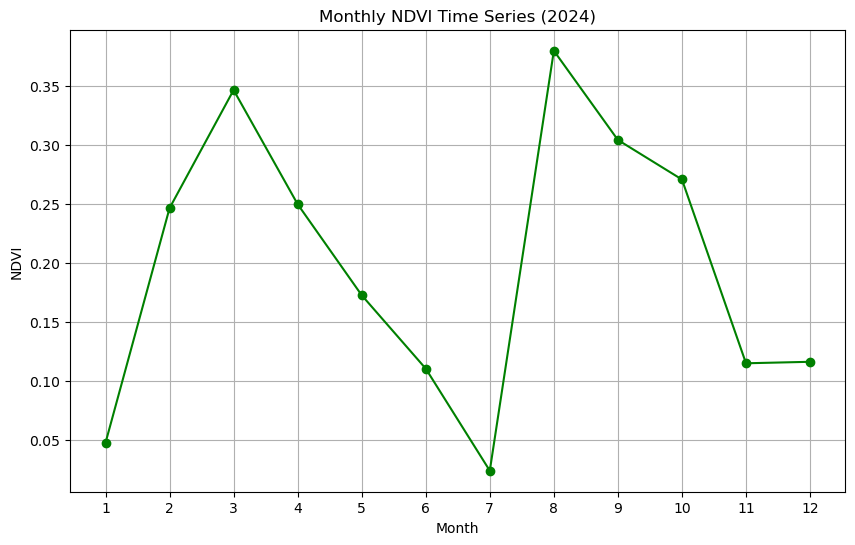

In [14]:

import ee
import pandas as pd
import matplotlib.pyplot as plt

# Add NDVI to each image in the collection
sentinel2_with_ndvi = sentinel2.map(calculate_ndvi)

# Function to calculate monthly NDVI mean for AOI
def calculate_monthly_ndvi(year, month):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')
    monthly_ndvi = sentinel2_with_ndvi.filterDate(start_date, end_date) \
        .select('NDVI') \
        .mean() \
        .reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=10
        )
    return ee.Dictionary({
        'month': month,
        'ndvi': monthly_ndvi.get('NDVI')
    })

# Generate a list of months
months = list(range(1, 13))

# Calculate monthly NDVI for each month
monthly_ndvi = ee.List([calculate_monthly_ndvi(2024, month) for month in months])

# Get the results as a list of dictionaries
monthly_ndvi_values = monthly_ndvi.getInfo()

# Convert the results to a DataFrame
df = pd.DataFrame(monthly_ndvi_values)

# Plot the NDVI time series
plt.figure(figsize=(10, 6))
plt.plot(df['month'], df['ndvi'], marker='o', linestyle='-', color='green')
plt.title("Monthly NDVI Time Series (2024)")
plt.xlabel("Month")
plt.ylabel("NDVI")
plt.xticks(ticks=months)
plt.grid(True)
plt.show()


Now, let's try an alternate method of finding the same NDVI but using downloaded tiles from the AOI and then local operations. Note that not all operations you need would be present on Google Earth Engine.

In [18]:
aoi_tif = ee.Image(ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
                   .filterBounds(aoi)
                   .first()
                   ).clip(aoi).getDownloadUrl({
                       'scale': 10,
                       'crs': 'EPSG:4326',
                       'region': aoi
                   })

print(aoi_tif)

import requests
response = requests.get(aoi_tif)
with open('aoi_tif.zip', 'wb') as f:
    f.write(response.content)



https://earthengine.googleapis.com/v1/projects/459426240313/thumbnails/ae0f8f646bcaa55b867120815acca402-9edd3225b5b252abbc9df3551092c5e0:getPixels


What did we just download? Let's see in QGIS.


In [19]:
! unzip aoi_tif.zip -d data/


Archive:  aoi_tif.zip
 extracting: data/20151207T053212_20151207T053215_T43RFP.B1.tif  
 extracting: data/20151207T053212_20151207T053215_T43RFP.B2.tif  
 extracting: data/20151207T053212_20151207T053215_T43RFP.B3.tif  
 extracting: data/20151207T053212_20151207T053215_T43RFP.B4.tif  
 extracting: data/20151207T053212_20151207T053215_T43RFP.B5.tif  
 extracting: data/20151207T053212_20151207T053215_T43RFP.B6.tif  
 extracting: data/20151207T053212_20151207T053215_T43RFP.B7.tif  
 extracting: data/20151207T053212_20151207T053215_T43RFP.B8.tif  
 extracting: data/20151207T053212_20151207T053215_T43RFP.B8A.tif  
 extracting: data/20151207T053212_20151207T053215_T43RFP.B9.tif  
 extracting: data/20151207T053212_20151207T053215_T43RFP.B10.tif  
 extracting: data/20151207T053212_20151207T053215_T43RFP.B11.tif  
 extracting: data/20151207T053212_20151207T053215_T43RFP.B12.tif  
 extracting: data/20151207T053212_20151207T053215_T43RFP.QA10.tif  
 extracting: data/20151207T053212_20151207T05321

In [20]:
! pip install rasterio

  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 5.8 MB/s eta 0:00:00a 0:00:01
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
Using cached affine-2.4.0-py3-none-any.whl (15 kB)
Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)


In [28]:
import rasterio
tif_file = 'data/20151207T053212_20151207T053215_T43RFP.B2.tif'
with rasterio.open(tif_file) as src:
    print(src.bounds)
    print(src.crs)
    print(src.transform)
    print(src.width, src.height)

    band_data = src.read(1) #reading the 1st band into the numpy array


BoundingBox(left=76.72654572110292, bottom=30.631742704719976, right=76.72968982459734, top=30.634168155987098)
EPSG:4326
| 0.00, 0.00, 76.73|
| 0.00,-0.00, 30.63|
| 0.00, 0.00, 1.00|
35 27


In [32]:
print(type(band_data))

band_data.shape

<class 'numpy.ndarray'>


(27, 35)

In [36]:
import numpy as np
print(np.min(band_data), np.max(band_data), np.median(band_data))
print(band_data)

0 1891 0.0
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 1774 1770 1763    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0 1789 1785 1778 1758 1762    0
     0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0 1787 1789 1789 1799 1806 1789 1781 1768
     0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 1796 1799 1786 1786 1791 1797 1801 1787 1796
  1799    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0 1788 1792 1785 1797 1785 1785 1784 1777 1792 1818 1816
  1809 1809    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0 

In [38]:
non_zero_count = np.count_nonzero(band_data)
print(non_zero_count)
print(35*27)


458
945


Let's understand what this array is

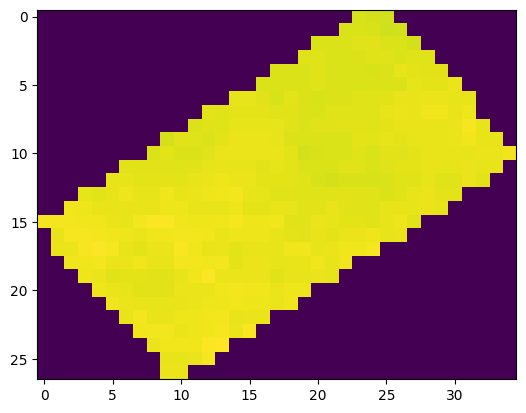

In [39]:
import matplotlib.pyplot as plt
plt.imshow(band_data)
plt.show()


Let's now see how to use shp files along with tifs to select data from rasters. 

[Reference Link](https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html)

In [1]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask

# Load the shapefile
gdf = gpd.read_file("data/potential-construction.shp")
geom = gdf.geometry.iloc[0]  # Assuming there's only one feature
shp_crs = gdf.crs  # Get the shapefile CRS

# Open the original TIFF file
with rasterio.open("data/20151207T053212_20151207T053215_T43RFP.B2.tif") as src:
    raster_crs = src.crs  # Get the raster CRS

    # Reproject geometry if CRS differs
    if shp_crs != raster_crs:
        # Reproject shapefile geometry to raster CRS using geopandas
        geom = geom.to_crs(raster_crs)

    # Mask the raster using the geometry
    geom_mask = [geom]  # Convert the geometry to GeoJSON-like format
    out_image, out_transform = mask(src, geom_mask, crop=True)

    # Update metadata for the new raster
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Write the masked raster to a new file
    with rasterio.open("output.tif", "w", **out_meta) as dst:
        dst.write(out_image)